# Time Series Forecasting Model Evaluation

### Imports

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np

from common import START_DATE, WINDOW_SIZE, TRAIN_TEST_RATIO
from helpers import *
from abstract import ForecastingMethod
from linear_regression import LinearRegression
from neural_network import NeuralNetwork
from pqc import PQC

2025-04-08 21:28:46.382680: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 21:28:46.383840: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 21:28:46.389236: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 21:28:46.400639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 21:28:46.418011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

### Training & Test Data Preparation

In [2]:
# Preprocess the data: apply normalization and scaling like the paper does
new_filepath, min_value, max_value, initial_value = (
    ForecastingMethod.preprocess_data(
        filepath="../data/paper-data.csv",
        difference=False,
        scale_to_range=True,
        training_data_cutoff=TRAIN_TEST_RATIO,
    )
)

# Load the data
X, y = ForecastingMethod.load_data(
    filepath=new_filepath, windows_size=WINDOW_SIZE
)
train_test_split_index = int(len(X) * TRAIN_TEST_RATIO)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=(1 - TRAIN_TEST_RATIO), shuffle=False
)

In [3]:
# Post process original data (for graphs only)
y_scaled = ForecastingMethod.post_process_data(
    y, min_value, max_value, initial_value, scale_to_range=True
)
X_scaled = ForecastingMethod.post_process_data(
    X, min_value, max_value, initial_value, scale_to_range=True
)
ORIG_SCALED = np.concatenate((X_scaled[0:WINDOW_SIZE, 0], y_scaled))
GRAPH_SPLIT_INDEX = train_test_split_index + WINDOW_SIZE

# Linear Regression

### Training - Model Creation & Weight Finding

In [4]:
models = [
    (
        "Linear Regression",
        LinearRegression(
            regularization=None, fit_intercept=False, cv_folds=None
        ),
    ),
    (
        "Linear Regression with Y-Intercept",
        LinearRegression(
            regularization=None, fit_intercept=True, cv_folds=None
        ),
    ),
    (
        "L1 Regularized Linear Regression",
        LinearRegression(
            regularization="l1",
            fit_intercept=True,
            cv_folds=5,
            alphas=[0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 1, 5, 10, 100],
        ),
    ),
    (
        "L2 Regularized Linear Regression",
        LinearRegression(
            regularization="l2",
            fit_intercept=True,
            cv_folds=5,
            alphas=[
                0.0001,
                0.001,
                0.01,
                0.1,
                0.3,
                0.5,
                1,
                2,
                3,
                4,
                5,
                6,
                7,
                10,
                100,
            ],
        ),
    ),
]

for name, model in models:
    model.train(X_train, y_train)

### Prediction - Timeseries Forecasting & Evaluation

In [5]:
for name, model in models:
    print("")
    print("#" * 50)
    print(name)
    print("#" * 50)
    print(f"Training Loss (MSE): {model.score(X_train, y_train)}")
    print(f"Testing Loss (MSE): {model.score(X_test, y_test)}")
    if "alpha" in model.model.get_params():
        print(f"Best Alpha: {model.model.get_params()["alpha"]}")


##################################################
Linear Regression
##################################################
Training Loss (MSE): 0.004362187562586465
Testing Loss (MSE): 0.039515172019350626

##################################################
Linear Regression with Y-Intercept
##################################################
Training Loss (MSE): 0.0035992407468405673
Testing Loss (MSE): 0.03680124805442622

##################################################
L1 Regularized Linear Regression
##################################################
Training Loss (MSE): 0.008584740568222893
Testing Loss (MSE): 0.029688163630002172
Best Alpha: 0.01

##################################################
L2 Regularized Linear Regression
##################################################
Training Loss (MSE): 0.005564872791968336
Testing Loss (MSE): 0.029718253368471066
Best Alpha: 0.3


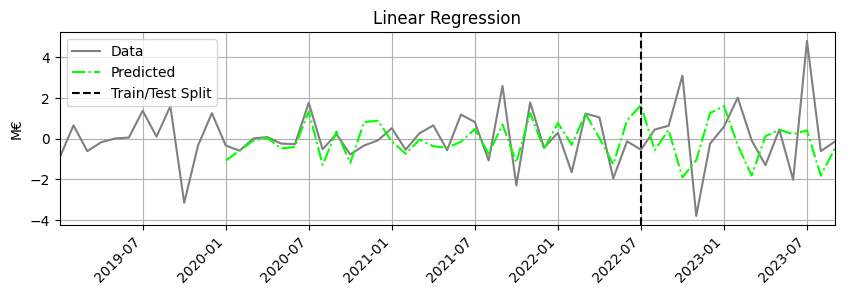

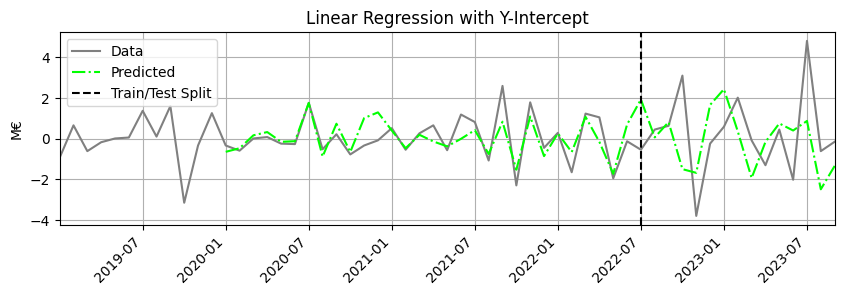

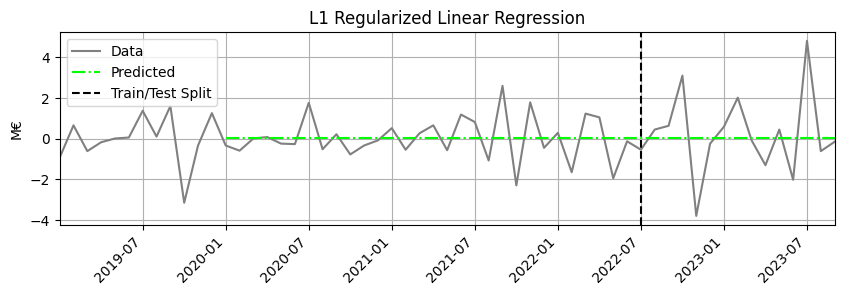

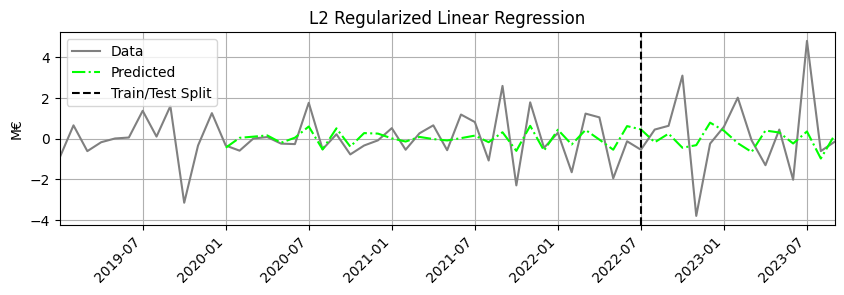

In [6]:
for name, model in models:
    # Post process predictions
    X_pred_scaled = ForecastingMethod.post_process_data(
        model.predict(X),
        min_value,
        max_value,
        initial_value,
        scale_to_range=True,
    )

    plot_sales_growth(
        START_DATE,
        ORIG_SCALED,
        X_pred_scaled,
        pred_linestyle="-.",
        pred_color="lime",
        title=name,
        train_test_split=GRAPH_SPLIT_INDEX,
        window_size=WINDOW_SIZE,
    )

# Neural Network

### Training - Model Creation & Weight Finding

In [7]:
nn = NeuralNetwork()
nn.train(X_train, y_train)

Epoch 1/200


2025-04-08 21:28:48.491113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-08 21:28:48.491465: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0092  
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 
Epoch 13/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 
Epoch 14/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 
Epoch 15/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 
Epoch 16/200
4/4 ━━━━━━━━━━━━━

### Prediction - Timeseries Forecasting & Evaluation

In [8]:
print(f"Training Loss (MSE): {nn.score(X_train, y_train)}")
print(f"Testing Loss (MSE): {nn.score(X_test, y_test)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Training Loss (MSE): 6.669403838240776e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Testing Loss (MSE): 0.02838838164602393


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


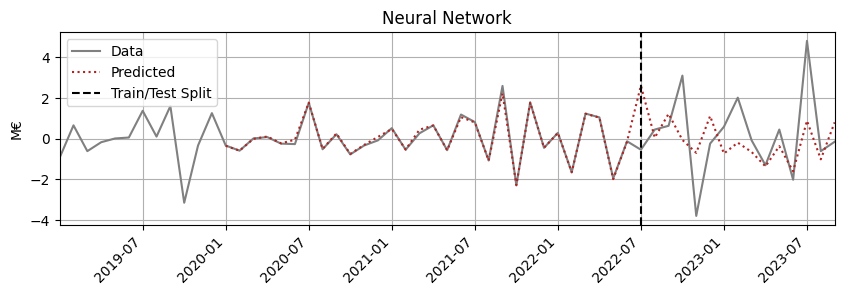

In [9]:
# Post process predictions
X_pred_scaled = ForecastingMethod.post_process_data(
    nn.predict(X), min_value, max_value, initial_value, scale_to_range=True
)

plot_sales_growth(
    START_DATE,
    ORIG_SCALED,
    X_pred_scaled,
    pred_linestyle=":",
    pred_color="firebrick",
    title="Neural Network",
    train_test_split=GRAPH_SPLIT_INDEX,
    window_size=WINDOW_SIZE,
)

# PQC

### Training - Model Creation & Weight Finding

In [ ]:
N_WIRES = 12
N_LAYERS = 2

# load the model - since training takes 30+ minutes
pqc_model_lbfgsb = PQC.load_model(
    filepath="../models/pqc_lbfgsb",
)
pqc_model_cobyla = PQC.load_model(
    filepath="../models/pqc_cobyla",
)

[0.20033883288797885, 0.17592642835440267, 0.17588493377249437, 0.1758658035843717, 0.1757543463767313, 0.17550113094184835, 0.17514733311835456, 0.17514356590936353, 0.17513217777830192, 0.1751267881968574, 0.17511412557511027, 0.17501189338001324, 0.17499825219028112, 0.17493362097164689, 0.17491743738780552, 0.17490203213791172, 0.1748727703057663, 0.174839376849617, 0.17472027375117308, 0.1746762177475853, 0.1745335630114481, 0.1745225120071067, 0.17448433573736488, 0.17445206183711032, 0.1744264967535807, 0.1744221179399036, 0.17441523093765582, 0.1744089917098677, 0.17440837132359133, 0.17440749329944238, 0.17440739655674703, 0.17440732327909803, 0.17440725785077074, 0.1744071960020846, 0.17440660710369335, 0.17440560830441806, 0.1744029969567611, 0.17440070612372668, 0.17439857156046512, 0.1743962123080667, 0.1743942095676499, 0.1743923303037183, 0.1743903859246411, 0.1743879163216254, 0.1743864675379037, 0.17438597932653982, 0.17438555632476865, 0.17438537416250993, 0.174385058

### Circuit Diagram

(<Figure size 1100x1300 with 1 Axes>, <Axes: >)

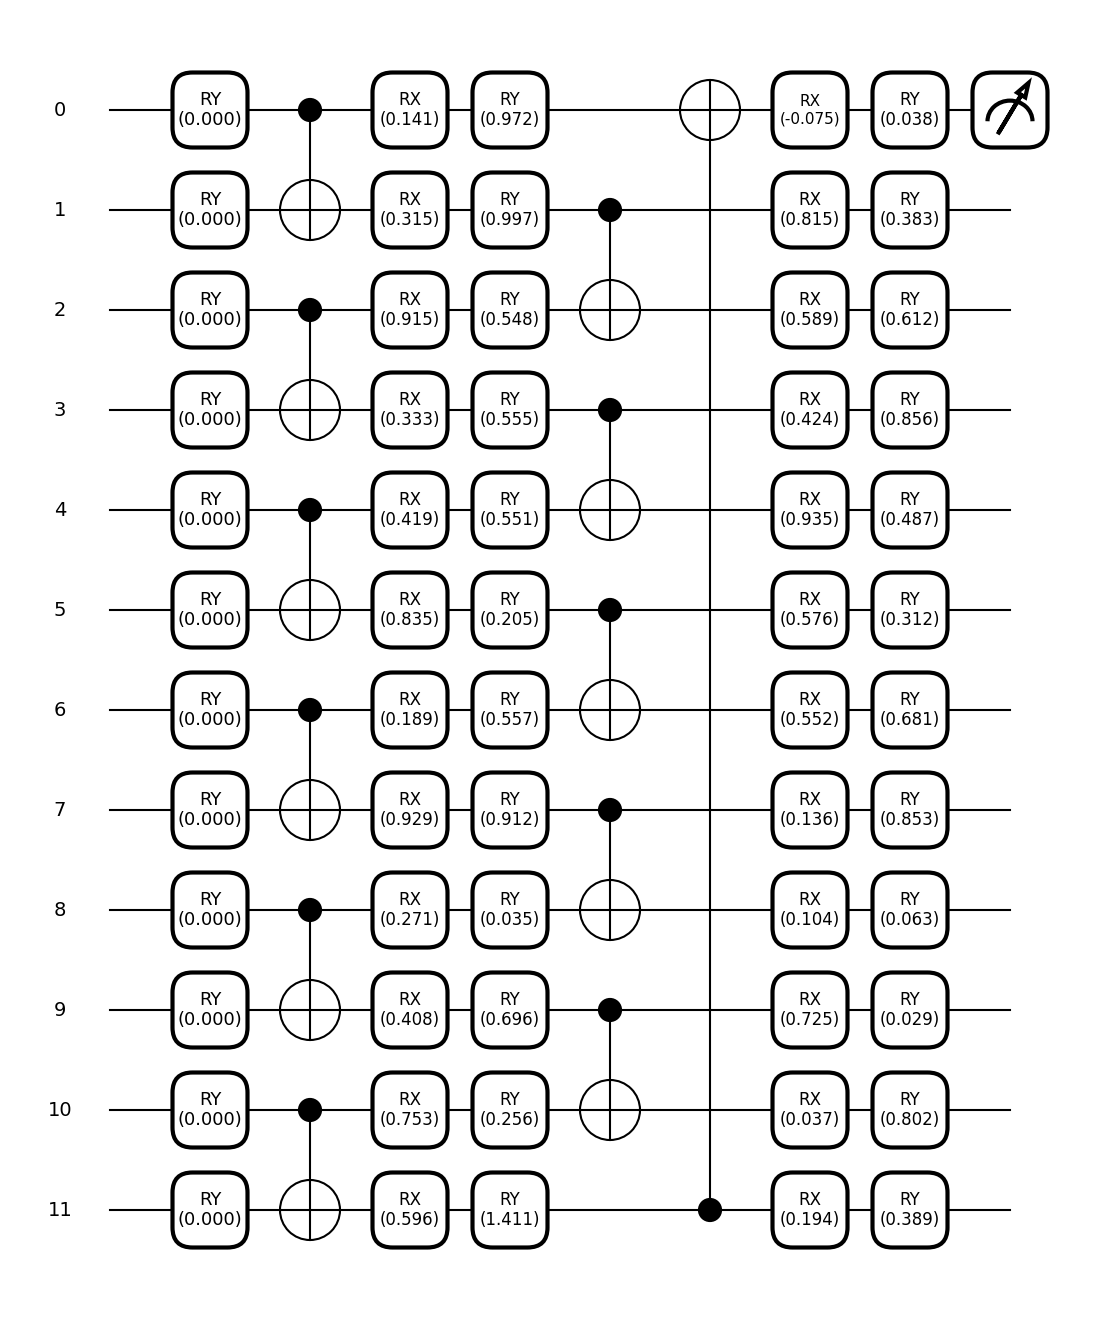

In [11]:
pqc_model_lbfgsb.draw_circuit()

### Prediction - Timeseries Forecasting & Evaluation

In [12]:
print("#" * 50)
print("PQC with L-BFGS-B Optimizer")
print("#" * 50)
print(f"Training Loss (MSE): {pqc_model_lbfgsb.score(X_train, y_train)}")
print(f"Testing Loss (MSE): {pqc_model_lbfgsb.score(X_test, y_test)}")
print("")
print("#" * 50)
print("PQC with COBYLA Optimizer")
print("#" * 50)
print(f"Training Loss (MSE): {pqc_model_cobyla.score(X_train, y_train)}")
print(f"Testing Loss (MSE): {pqc_model_cobyla.score(X_test, y_test)}")

##################################################
PQC with L-BFGS-B Optimizer
##################################################
Training Loss (MSE): 0.005812808093107994
Testing Loss (MSE): 0.025996950885068155

##################################################
PQC with COBYLA Optimizer
##################################################
Training Loss (MSE): 0.005892445950097202
Testing Loss (MSE): 0.024592929549130473


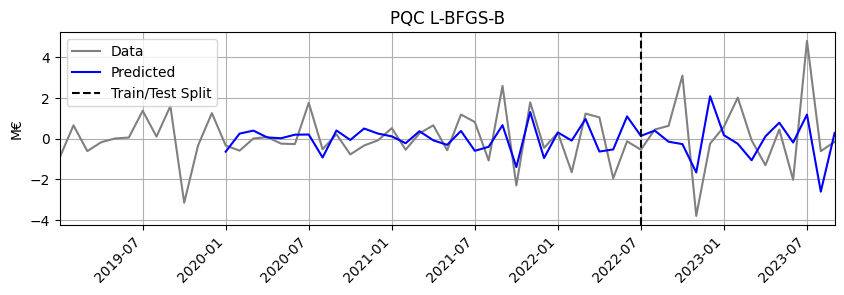

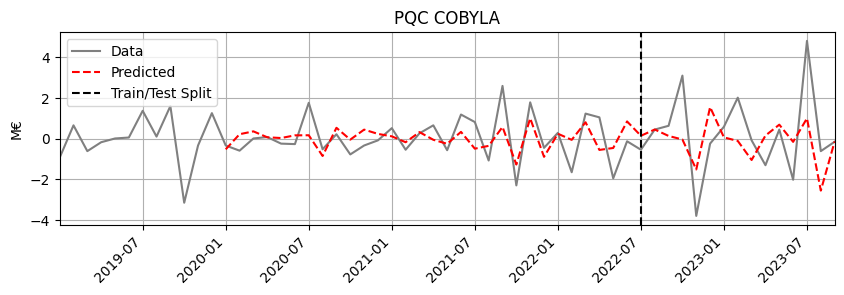

In [13]:
# Post process predictions
predictions_L_scaled = ForecastingMethod.post_process_data(
    pqc_model_lbfgsb.predict(X),
    min_value,
    max_value,
    initial_value,
    scale_to_range=True,
)
predictions_C_scaled = ForecastingMethod.post_process_data(
    pqc_model_cobyla.predict(X),
    min_value,
    max_value,
    initial_value,
    scale_to_range=True,
)

# Plot the results
plot_sales_growth(
    START_DATE,
    ORIG_SCALED,
    predictions_L_scaled,
    pred_linestyle="-",
    pred_color="blue",
    title="PQC L-BFGS-B",
    train_test_split=GRAPH_SPLIT_INDEX,
    window_size=WINDOW_SIZE,
)
plot_sales_growth(
    START_DATE,
    ORIG_SCALED,
    predictions_C_scaled,
    pred_linestyle="--",
    pred_color="red",
    title="PQC COBYLA",
    train_test_split=GRAPH_SPLIT_INDEX,
    window_size=WINDOW_SIZE,
)